# Text Classification

<hr>

This notebook presents an example of the practical exercises from Chapter Two of Book [Natural Language Processing with Transformers](https://www.oreilly.com/library/view/natural-language-processing/9781098136789/).

Created by [Anderson Silva](https://github.com/andsfonseca), Mayara Gomes and [Nelia Reis](https://github.com/neliareis).

<hr>

This notebook has references to other notebooks and codes such as:

* [One-hot Vectors](./one_hot_vector.ipynb)
* [Text Classification with Tensorflow](./text_classification_tensorflow.ipynb)


## The Dataset

To build our emotion detector we’ll use a great dataset from an article that explored
how emotions are represented in English Twitter messages, called [CARER: Contextualized Affect Representations for Emotion Recognition](http://dx.doi.org/10.18653/v1/D18-1404).

### A First Look at Hugging Face Datasets

We will use Datasets to download the data from the Hugging Face Hub. You can also access the list of all datasets from this [repository](https://github.com/huggingface/datasets).

In [1]:
from datasets import load_dataset

In [2]:
# Load the emotion dataset with the load_dataset() function:
emotions = load_dataset("emotion")
emotions

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/andsfonseca/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
# We can use the usual dictionary syntax to access an individual split:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
# Getting some information about the dataset:
print("Length: ", len(train_ds))
print("Column names:", train_ds.column_names)
print("Values: ", train_ds.features)
print("Access a single example by its index:", train_ds[0])

Length:  16000
Column names: ['text', 'label']
Values:  {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
Access a single example by its index: {'text': 'i didnt feel humiliated', 'label': 0}


### From Datasets to DataFrames

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a **Dataset** object to a **Pandas DataFrame** so we can access high-level APIs for data visualization.

In [5]:
import pandas as pd

In [6]:
# The set_format() method that allows us to change the output format of the Dataset.
emotions.set_format(type="pandas")

df_train = emotions["train"][:]
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
# Creating a method to show the label name and put in a new column in our DataFrame with the corresponding label:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [8]:
df_train["label_name"] = df_train["label"].apply(label_int2str)
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes.

In [9]:
import matplotlib.pyplot as plt

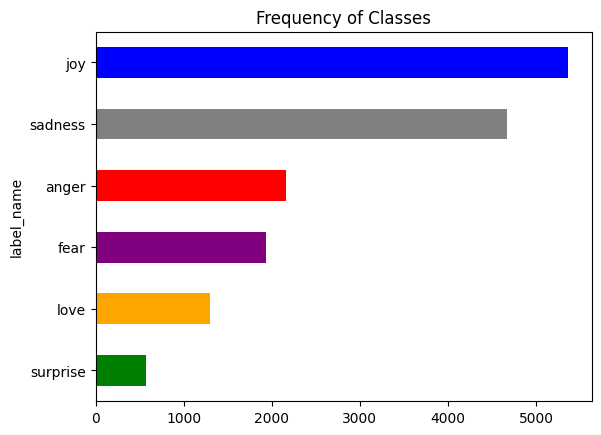

In [10]:

df_train["label_name"].value_counts(ascending=True).plot(kind='barh', color=["g", "orange", "purple", "r", "gray", "b"])

plt.title("Frequency of Classes")
plt.show()

### How Long Are Our Tweets?

We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet.

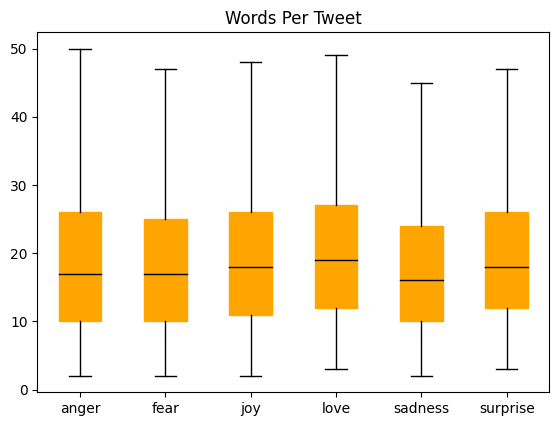

In [11]:
df_train["Words Per Tweet"] = df_train["text"].str.split().apply(len)

props = dict(boxes="Orange", whiskers="Black", medians="Black", caps="Black")
boxplot = df_train.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color=props, patch_artist=True)

plt.suptitle("")
plt.xlabel("")
plt.show()

In [12]:
# Reset the output format of our dataset since we don’t need the DataFrame format anymore:
emotions.reset_format()

## From Text to Tokens

Transformer models like [DistilBERT](https://huggingface.co/distilbert-base-uncased-distilled-squad) cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model.


### Character Tokenization

The simplest tokenization scheme is to feed each character individually to the model.

In [13]:
# This text will be our example.
example_text = df_train["text"][31]
example_text

'i remember feeling acutely distressed for a few days'

In [14]:
# Character-level tokenization
tokenized_example_text = list(example_text)
print(tokenized_example_text)

['i', ' ', 'r', 'e', 'm', 'e', 'm', 'b', 'e', 'r', ' ', 'f', 'e', 'e', 'l', 'i', 'n', 'g', ' ', 'a', 'c', 'u', 't', 'e', 'l', 'y', ' ', 'd', 'i', 's', 't', 'r', 'e', 's', 's', 'e', 'd', ' ', 'f', 'o', 'r', ' ', 'a', ' ', 'f', 'e', 'w', ' ', 'd', 'a', 'y', 's']


In [15]:
# Encoding each unique token (which are characters in this case) with a unique integer:
token2id_example = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_example_text)))}

print(token2id_example)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'i': 8, 'l': 9, 'm': 10, 'n': 11, 'o': 12, 'r': 13, 's': 14, 't': 15, 'u': 16, 'w': 17, 'y': 18}


In [16]:
# Each token has now been mapped to a unique numerical identifier (hence the name input_ids).
tokenized_example_ids = [token2id_example[token] for token in tokenized_example_text]
print(tokenized_example_ids)

[8, 0, 13, 5, 10, 5, 10, 2, 5, 13, 0, 6, 5, 5, 9, 8, 11, 7, 0, 1, 3, 16, 15, 5, 9, 18, 0, 4, 8, 14, 15, 13, 5, 14, 14, 5, 4, 0, 6, 12, 13, 0, 1, 0, 6, 5, 17, 0, 4, 1, 18, 14]


<hr style="height:2px;border:none;background-color:gray;"></hr>

##### One-hot vectors

Each token has now been mapped to a unique numerical identifier (hence the name input_ids). The last step is to convert input_ids to a 2D tensor of one-hot vectors. You can see a example in this notebook [One-hot Vectors](./one_hot_vector.ipynb)

<hr style="height:2px;border:none;background-color:gray;"></hr>

In [17]:
import torch
import torch.nn.functional as F

In [18]:
input_ids = torch.tensor(tokenized_example_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2id_example))

# For each of the 52 input tokens we now have a one-hot vector with 19 dimensions, since our vocabulary consists of 19 unique characters.
one_hot_encodings.shape

torch.Size([52, 19])

In [19]:
print(f"Token: {tokenized_example_text[0]}")
print(f"Tensor index: {tokenized_example_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: i
Tensor index: 8
One-hot: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization

Instead of splitting the text into characters, we can split it into words and map each word to an integer.

In [20]:
# One simple class of word tokenizers uses whitespace to tokenize the text.
tokenized_word_example_text = example_text.split()
tokenized_word_example_text

['i',
 'remember',
 'feeling',
 'acutely',
 'distressed',
 'for',
 'a',
 'few',
 'days']

In [21]:
# Encoding each unique token (which are words in this case) with a unique integer:
token2id_word_example = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_word_example_text)))}
print(token2id_word_example)

{'a': 0, 'acutely': 1, 'days': 2, 'distressed': 3, 'feeling': 4, 'few': 5, 'for': 6, 'i': 7, 'remember': 8}


In [22]:
# Each token has now been mapped to a unique numerical identifier (hence the name input_ids).
tokenized_word_example_ids = [token2id_word_example[token] for token in tokenized_word_example_text]
print(tokenized_word_example_ids)

[7, 8, 4, 1, 3, 6, 0, 5, 2]


In [23]:
# This tokens as One-hot vector
input_ids = torch.tensor(tokenized_word_example_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2id_word_example))

print(f"Token: {tokenized_word_example_text[2]}")
print(f"Tensor index: {tokenized_word_example_ids[2]}")
print(f"One-hot: {one_hot_encodings[2]}")

Token: feeling
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0])


### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size.

There are several subword tokenization algorithms that are commonly used in NLP, but let’s start with WordPiece,5 which is used by the BERT and DistilBERT tokenizers.

In [24]:
from transformers import DistilBertTokenizer

In [25]:
# Load the tokenizer associated with a pretrained model using the method from_pretrained()
model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [26]:
# Encoding each unique token (which are words or sub-words in this case) with a unique integer:
encoded_text = distilbert_tokenizer(example_text)

print(example_text)
print(encoded_text["input_ids"])

i remember feeling acutely distressed for a few days
[101, 1045, 3342, 3110, 11325, 2135, 24305, 2005, 1037, 2261, 2420, 102]


In [27]:
# Exploring the tokens
tokens = distilbert_tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'i',
 'remember',
 'feeling',
 'acute',
 '##ly',
 'distressed',
 'for',
 'a',
 'few',
 'days',
 '[SEP]']

In [28]:
# Turning the tokens back to string
distilbert_tokenizer.convert_tokens_to_string(tokens)

'[CLS] i remember feeling acutely distressed for a few days [SEP]'

In [29]:
# Some properties of the distilibert tokenizer:
print(f"Vocabulary Size: {distilbert_tokenizer.vocab_size}")
print(f"Context Size of the Tokenizer: {distilbert_tokenizer.model_max_length}")
print(f"Input names: {distilbert_tokenizer.model_input_names}")

Vocabulary Size: 30522
Context Size of the Tokenizer: 512
Input names: ['input_ids', 'attention_mask']


### Tokenizing the Whole Dataset

Now, we try to apply a tokeninzer in the entire dataset.

In [30]:
# A processing function to tokenize our examples
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)

In [31]:
# To see tokenize() in action, let’s pass a batch of two examples from the training set:
print(tokenize(emotions["train"][:2])["input_ids"])

[[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]]


These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

|   Special Token  | [PAD] | [UNK] | [CLS] | [SEP] | [MASK] |
|:----------------:|:-----:|:-----:|:-----:|:-----:|:------:|
| Special Token ID |   0   |  100  |  101  |  102  |   103  |

In [32]:
# Exploring the tokens
tokens = distilbert_tokenizer.convert_ids_to_tokens(tokenize(emotions["train"][:2])["input_ids"][0])
tokens

['[CLS]',
 'i',
 'didn',
 '##t',
 'feel',
 'humiliated',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [33]:
# Apply it across all the splits in the dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-fc5b5c6c07369ad1.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-177bbc180abd22e9.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-42c6f6b0ef07b3a9.arrow


In [34]:
# Comparing the result
for i in range(1):
    row = emotions_encoded["train"][i]  
    print(row["text"]) 
    print(row["input_ids"]) 

i didnt feel humiliated
[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Training a Text Classifier

We have two options to train such a model on our Twitter dataset:

* Feature extraction

    We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

* Fine-tuning

    We train the whole model end-to-end, which also updates the parameters of the pretrained model.


### Transformers as Feature Extractor

Using a transformer as a feature extractor is fairly simple. We freeze the body’s weights during training and use the hidden states as features for the classifier.

#### Using pretrained models

The AutoModel has a from_pretrained() method to load the weights of a pretrained model. Let’s use this method to load the [DistilBERT](https://huggingface.co/distilbert-base-uncased-distilled-squad) checkpoint:

In [35]:
from transformers import AutoModel

In [36]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


> The default framework of this notebook is PyTorch. If you want, we provide a notebook that uses Tensorflow framework instead of PyTorch. You can see here in [Text Classification with Tensorflow](./text_classification_tensorflow.ipynb)

#### Extracting the last hidden states

To warm up, let’s retrieve the last hidden states for a single string

In [37]:
# Example Text
example_text

'i remember feeling acutely distressed for a few days'

In [38]:
# Encode the string and convert the tokens to PyTorch tensors.
inputs = distilbert_tokenizer(example_text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 12])


In [39]:
# The final step is to place them on the same device as the model and pass the inputs
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[ 0.0267,  0.0243, -0.1351,  ...,  0.0231,  0.1226,  0.2348],
         [ 0.3981,  0.1839, -0.3101,  ...,  0.1541,  0.6333,  0.0120],
         [-0.0371,  0.1825, -0.0489,  ...,  0.0914, -0.3788, -0.2676],
         ...,
         [-0.2624, -0.3020,  0.2109,  ..., -0.3921, -0.6568, -0.0390],
         [-0.2264, -0.1025, -0.0399,  ..., -0.1844, -0.3466, -0.4665],
         [ 0.9699,  0.1726, -0.3798,  ...,  0.2346, -0.4845, -0.4161]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [40]:
print(f"Shape of the last hidden state: {outputs.last_hidden_state.size()}")
print(f"Shape of the last hidden state of [CLS]: {outputs.last_hidden_state[:,0].size()}")


Shape of the last hidden state: torch.Size([1, 12, 768])
Shape of the last hidden state of [CLS]: torch.Size([1, 768])


In [41]:
# the same for the whole dataset by creating a new hidden_state column that stores all these vectors. 

def extract_hidden_states(batch):
    # Place model inputs on the device
    inputs = {k:v.to(device) for k,v in batch.items() if k in distilbert_tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [42]:
# The model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [43]:
# Extract the hidden states across all splits
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=512)

Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-3697ead2643d07bf.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-ba293d16c35cf5f3.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-14c96dd14177ecf4.arrow


In [44]:
# Applying the extract_hidden_states() function has added a new hidden_state column to our dataset
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets.

In [45]:
import numpy as np

In [46]:
# Create the corresponding arrays in the well-known Scikit-learn format
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we’ll use the powerful [UMAP](https://arxiv.org/abs/1802.03426) algorithm to project the vectors down to 2D.

In [47]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [48]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.795794,6.683904,0
1,-2.642506,6.304759,0
2,5.538398,3.100778,3
3,-2.110481,4.305466,2
4,-3.110785,4.415710,3


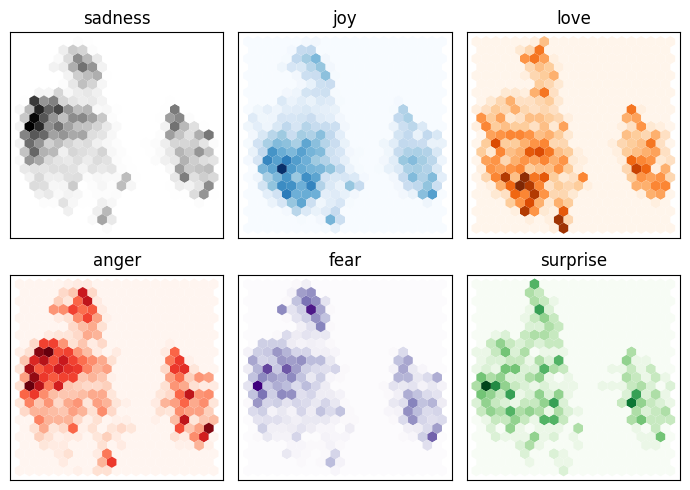

In [49]:
# Showing the compressed data and plot the density of points for each category separately
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

#### Training a simple classifier

Let’s use these hidden states to train a logistic regression and dummy classifier with a basic heuristic model with Scikit-learn

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [52]:
from sklearn.dummy import DummyClassifier

In [53]:
# DummyClassifier can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class.
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [55]:
# Let's investigate the performance of the model by looking at the confusion matrix of the classifier
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

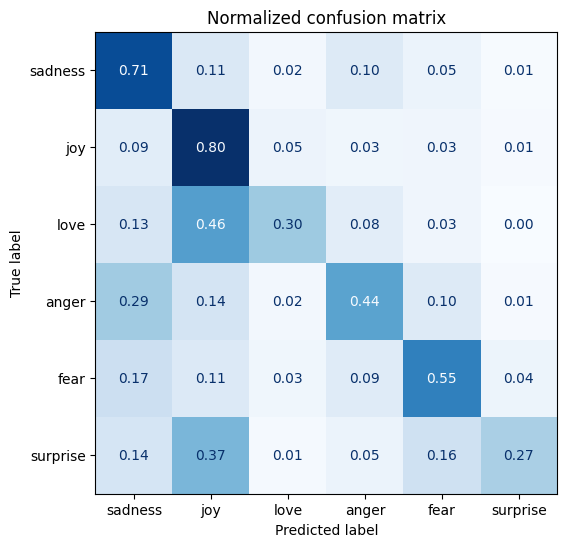

In [56]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Transformers

With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them.

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. 

In [57]:
from transformers import AutoModelForSequenceClassification


In [58]:
# The AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs
num_labels = 6
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt, num_labels=num_labels)
 .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

#### Defining the performance metric

To monitor metrics during training, we need to define a compute_metrics() function for the Trainer

In [59]:
from sklearn.metrics import accuracy_score, f1_score

In [60]:
# This function receives an EvalPrediction object (which is a named tuple with predictions and label_ids attributes) and 
# needs to return a dictionary that maps each metric’s name to its value
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

Let's start with the training

In [61]:
from transformers import Trainer, TrainingArguments

In [62]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
output_dir = f"models/{model_name}"

# This class stores a lot of information and gives you fine-grained control over the training and evaluation. 
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [63]:
# We can instantiate and fine-tune our model with the Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=distilbert_tokenizer)
trainer.train()

d:\Documents\Workspaces\Python\nlp-with-transformers\.venv\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.8242, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.31060096621513367, 'eval_accuracy': 0.91, 'eval_f1': 0.9084206502030105, 'eval_runtime': 9.4892, 'eval_samples_per_second': 210.767, 'eval_steps_per_second': 3.372, 'epoch': 1.0}
{'loss': 0.2457, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.22038090229034424, 'eval_accuracy': 0.925, 'eval_f1': 0.925141788601606, 'eval_runtime': 9.8911, 'eval_samples_per_second': 202.202, 'eval_steps_per_second': 3.235, 'epoch': 2.0}
{'train_runtime': 723.0485, 'train_samples_per_second': 44.257, 'train_steps_per_second': 0.692, 'train_loss': 0.5349457092285156, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5349457092285156, metrics={'train_runtime': 723.0485, 'train_samples_per_second': 44.257, 'train_steps_per_second': 0.692, 'train_loss': 0.5349457092285156, 'epoch': 2.0})

In [64]:
# The predict() method of the Trainer class returns several useful objects we can use for evaluation.
preds_output = trainer.predict(emotions_encoded["validation"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [65]:
# The metrics on the validation set can be accessed as follows:
preds_output.metrics

{'test_loss': 0.22038090229034424,
 'test_accuracy': 0.925,
 'test_f1': 0.925141788601606,
 'test_runtime': 9.64,
 'test_samples_per_second': 207.468,
 'test_steps_per_second': 3.319}

In [66]:
# We can decode the predictions greedily using np.argmax(). This yields the predicted labels and has the same format as the labels returned
y_preds = np.argmax(preds_output.predictions, axis=1)

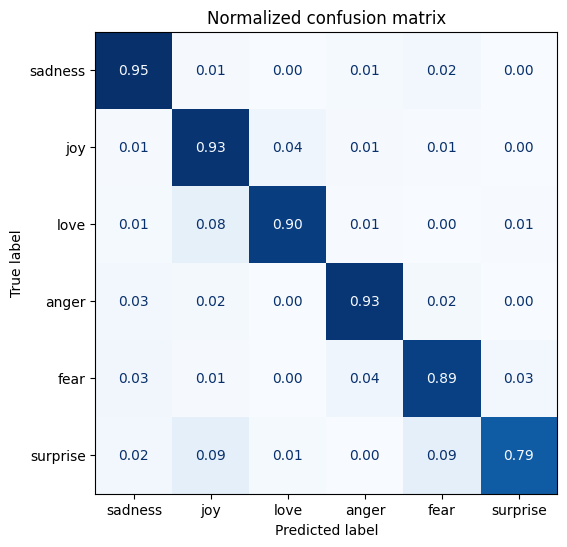

In [67]:
# We can take a more detailed look at the training metrics by calculating the confusion matrix.
plot_confusion_matrix(y_preds, y_valid, labels)

#### Error analysis

We should investigate our model’s predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss.

In [68]:
from torch.nn.functional import cross_entropy

In [69]:
# A function that returns the loss along with the predicted labe
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in distilbert_tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
        reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [70]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [71]:
# Create a DataFrame with the texts, losses, and predicted/true labels
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [72]:
# Sort the data by the highest losses:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.824822
882,i feel badly about reneging on my commitment t...,love,sadness,5.609470
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.087307
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.083751
1963,i called myself pro life and voted for perry w...,joy,sadness,5.069043
1950,i as representative of everything thats wrong ...,surprise,sadness,5.034863
1662,i did not directly react to the spot fixing co...,joy,anger,4.627516
1274,i am going to several holiday parties and i ca...,joy,sadness,4.538637
1964,i feel vaguely cheated and a little amused,joy,anger,4.431739
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.412879


In [73]:
# Sort the data by the smallest losses:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.017635
199,i feel invigorated full of energy ready for th...,joy,joy,0.017649
1090,i dont know what it is about me and sweets the...,joy,joy,0.017674
1548,im not feeling very festive this year,joy,joy,0.017737
131,i feel like a graph doesnt show the data accur...,joy,joy,0.017760
578,i got to christmas feeling positive about the ...,joy,joy,0.017881
19,i had lunch with an old friend and it was nice...,joy,joy,0.018011
1649,i feel relieved when she goes to bed because s...,joy,joy,0.018111
4,i can have for a treat or if i am feeling festive,joy,joy,0.018147
1099,i feel invigorated when i look at this image j...,joy,joy,0.018250


#### Saving and using the model

We can also use the fine-tuned model to make predictions on new tweets.

In [74]:
from transformers import pipeline

In [75]:
# Load the pipeline
classifier = pipeline("text-classification", model=model, tokenizer=distilbert_tokenizer, device=0)

In [76]:
# Let’s test the pipeline with a sample tweet
example2_text = "I saw a movie today and it was really good."
preds = classifier(example2_text, return_all_scores=True)

d:\Documents\Workspaces\Python\nlp-with-transformers\.venv\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


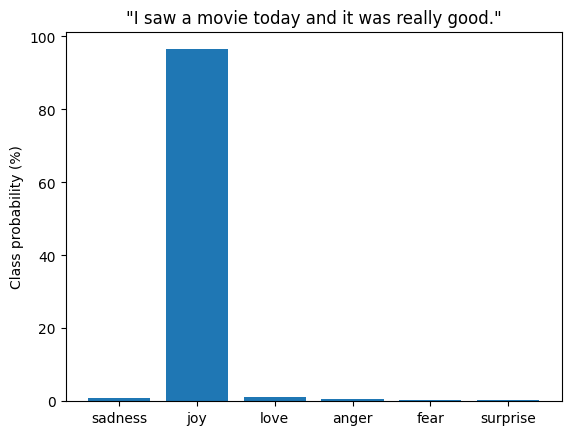

In [77]:
# We can plot the probability for each class in a bar plot.
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{example2_text}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion

Congratulations, you now know how to train a transformer model to classify the emotions in tweets! We have seen two complementary approaches based on features and fine-tuning, and investigated their strengths and weaknesses.